# Libraries

In [2]:
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from metadata import ImageDataset, patient
import utils

In [4]:
notebooks_path = Path.cwd()
repo_path = notebooks_path.parent
print(f'The current directory is: {notebooks_path}')

The current directory is: /home/ricardino/Documents/MAIA/tercer_semestre/MISA/final_project/MISA_FINAL_PROJECT/notebooks


# Functions

In [5]:
def get_pixels(im_path:str, mask_path:str, tissue_num:int):
    """given the image and the mask path this function returns the pixels for a specific tissue number.
    The tissue number is a int from 0 to 2, where 1 is CSF, 2 is GM and 3 is WM, according to the ground truth.

    Args:
        im_path (str): image path
        mask_path (str): mas path
        tissue_num (int): tissue number [0,2]

    Returns:
        array: extracted pixels in a flat array
    """
    im_array = sitk.GetArrayFromImage(sitk.ReadImage(str(im_path)))
    mask_array = sitk.GetArrayFromImage(sitk.ReadImage(str(mask_path)))
    
    return np.extract(mask_array.ravel() == tissue_num, im_array.ravel())


def get_maxmin_intensity(im_data):

    max_int = 0 #initialize max intensity
    min_int = 0 #initialize min intensity

    for im_path, mask_path in zip(im_data.im_paths(preprocess=True), im_data.labels_paths()):
        
        im_path = str(repo_path / im_path)
        mask_path = str(repo_path / mask_path)
        
        csf_ext = get_pixels(im_path, mask_path, tissue_num=1) #Extract pixels for tissue 1 (CSF)
        wm_ext = get_pixels(im_path, mask_path, tissue_num=2) #Extract pixels for tissue 2 (WM)
        gm_ext = get_pixels(im_path, mask_path, tissue_num=3) #Extract pixels for tissue 3 (GM)

        max_int_pat = np.max([csf_ext.max(), wm_ext.max(), gm_ext.max()]) #Get maximum inensity
        min_int_pat = np.min([csf_ext.min(), wm_ext.min(), gm_ext.min()]) #Get minimum inensity
        if max_int_pat > max_int: #Substitute global maximum if necessary
            max_int = max_int_pat
        if min_int_pat < min_int:
            min_int = min_int_pat

    print(f'The maximum intensity is {max_int}')
    print(f'The minimum intensity is {min_int}')
    return max_int, min_int

In [6]:
def get_atlas_histogram(list_patient):        
    #Define range of intensity values
    max_int = 3077 + 1; min_int = 0
    bins = np.arange(min_int, max_int + 1) #Define bins for histogram (Numpy bin_edges are open intervals on the right)

    #Store count values in array
    tot_csf = np.zeros(shape=(max_int,))
    tot_wm = np.zeros(shape=(max_int,))
    tot_gm = np.zeros(shape=(max_int,))

    for f in list_patient:
        
        im_path = str(repo_path) + f'/data/training-set/training-images/10{f}.nii.gz'
        mask_path = str(repo_path) + f'/data/training-set/training-labels/10{f}_3C.nii.gz'

        csf_ext = get_pixels(im_path, mask_path, tissue_num=1) #Extract pixels for tissue 1 (CSF)
        wm_ext = get_pixels(im_path, mask_path, tissue_num=2) #Extract pixels for tissue 2 (WM)
        gm_ext = get_pixels(im_path, mask_path, tissue_num=3) #Extract pixels for tissue 3 (GM)

        val_csf, _ = np.histogram(csf_ext, bins=bins)
        val_wm, _ = np.histogram(wm_ext, bins=bins)
        val_gm, _ = np.histogram(gm_ext, bins=bins)

        tot_csf += val_csf
        tot_wm += val_wm
        tot_gm += val_gm
    return tot_csf, tot_wm, tot_gm, bins

In [7]:
def normalize_histogram(tot_csf, tot_wm, tot_gm):
    tot_csf = tot_csf/np.sum(tot_csf)
    tot_wm = tot_wm/np.sum(tot_wm)
    tot_gm = tot_gm/np.sum(tot_gm)
    
    return tot_csf, tot_wm, tot_gm

# Section 0: Check ground truth

We check that the ground truth has the order we expect: CSF (1), GM (2) and WM (3).

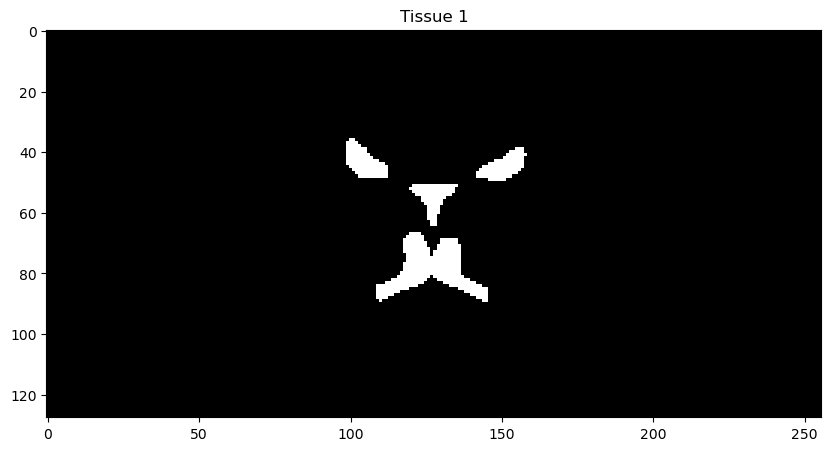

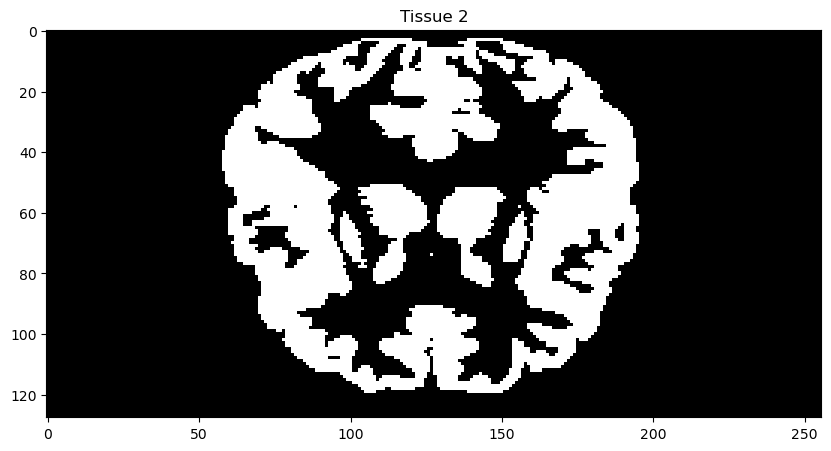

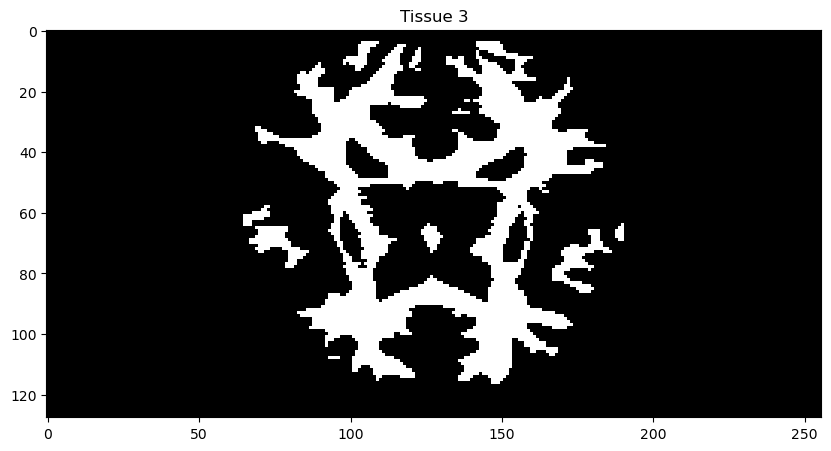

In [10]:
im_data = ImageDataset(set_name='Training')
id = im_data.IDs[0]
pat = patient(id, im_data)

im_array = pat.labels(format='np')
for tissue in range(1,4):    
    plt.figure(figsize=(10,10))
    plt.title(f'Tissue {tissue}')
    plt.imshow(im_array[140,:,:]==tissue, cmap='gray')

# Section 1: Get the minimum and maximum intensity

We get the minimum and maximum intensity value among all to define a range.
Range result = (0, 3077)

In [7]:
max_int, min_int = get_maxmin_intensity(im_data)

The maximum intensity is 1.784318909857607
The minimum intensity is 0


# Section 2: Accumulated histogram across all patients

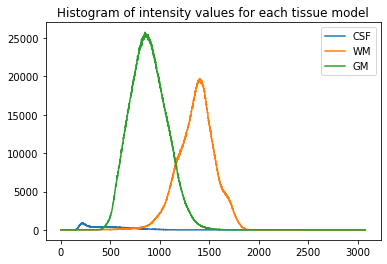

In [8]:
#Now we can extract a histogram for each tissue and each patient
list_patient = ['00', '01', '02', '06','07', '08', '09', '10','11', '12', '13', '14','15', '17', '36'] #All patients

tot_csf, tot_wm, tot_gm, bins = get_atlas_histogram(list_patient)

#Plot three histograms given values and bins
plt.plot(bins[:-1], tot_csf, label='CSF')
plt.plot(bins[:-1], tot_wm, label='WM')
plt.plot(bins[:-1], tot_gm, label='GM')
plt.legend()
plt.title('Histogram of intensity values for each tissue model')
plt.show()

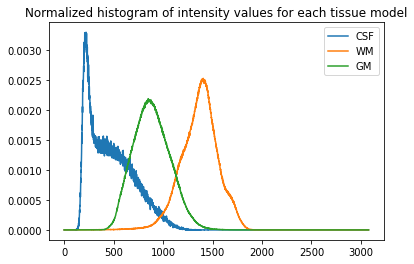

In [9]:
norm_hist = normalize_histogram(tot_csf, tot_wm, tot_gm)

#Plot three histograms given values and bins
plt.plot(bins[:-1], norm_hist[0], label='CSF')
plt.plot(bins[:-1], norm_hist[1], label='WM')
plt.plot(bins[:-1], norm_hist[2], label='GM')
plt.legend()
plt.title('Normalized histogram of intensity values for each tissue model')
plt.show()


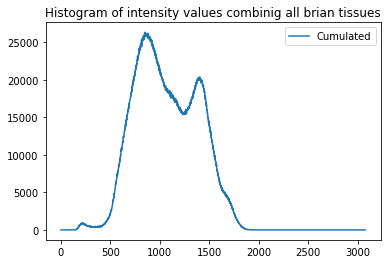

In [10]:
#Now we combine the counts of the three tissues to preper for normalisation.
three_hist = np.array([tot_csf,tot_wm,tot_gm]).T
three_sum = np.sum([tot_csf,tot_wm,tot_gm], axis=0)
plt.plot(bins[:-1], three_sum, label='Cumulated')
plt.legend()
plt.title('Histogram of intensity values combinig all brian tissues')
plt.show()


# Section 3: Tissue model

/tmp/ipykernel_46896/3667550131.py:2: RuntimeWarning: invalid value encountered in true_divide
  three_hist_norm = three_hist/three_sum[:,None]


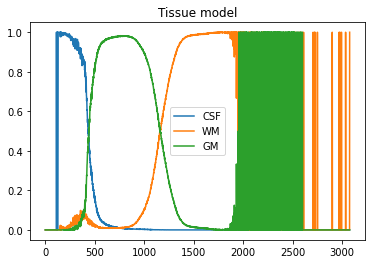

In [11]:
#Normilize histogram bin-wise
three_hist_norm = three_hist/three_sum[:,None]
#Make nan values 0
tissue_model = np.nan_to_num(three_hist_norm)
#plot tissue model
plt.plot(bins[:-1], tissue_model[:,0], label='CSF')
plt.plot(bins[:-1], tissue_model[:,1], label='WM')
plt.plot(bins[:-1], tissue_model[:,2], label='GM')
plt.legend()
plt.title('Tissue model')
plt.show()

In [25]:
#Save tissue model
with open(str(repo_path) + '/data/atlas_results/tissue_model.p', 'wb') as f:
    pickle.dump(tissue_model, f)